src/02_modeling.py — Cox Models, Survival Analysis, ML Pipelines

In [1]:
#1 Mount Google Drive for File Access
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Step#1:** This initial step establishes a connection between the Colab notebook and the user's Google Drive. By importing the drive module from google.colab and invoking drive.mount('/content/drive'), the notebook prompts the user to authorize access to their Google Drive. Once authorized, the Drive is mounted at the /content/drive path, allowing the notebook to read from and write to files stored in the user's Drive. This is essential for workflows that rely on external datasets, saved models, or persistent storage across sessions.

In [2]:
#2 Define Project Paths and Ensure Output Directory
import os
import pandas as pd
project_root = '/content/drive/MyDrive/fsgs_Kidney_Disease_study'
data_path = os.path.join(project_root, 'data', 'processed', 'fsgs_dataset_cleaned.csv')
output_path = os.path.join(project_root, 'outputs', 'modeling')
os.makedirs(output_path, exist_ok=True)

**Step#2:** This step sets up the foundational file paths for the FSGS Kidney Disease study. It begins by importing the os and pandas libraries, which are essential for file handling and data manipulation. The variable project_root defines the base directory within Google Drive where all project files are stored. Using os.path.join, it constructs a path to the cleaned dataset (fsgs_dataset_cleaned.csv) located in the data/processed subfolder. It also defines an output_path for storing modeling results, and ensures this directory exists by calling os.makedirs with exist_ok=True, which avoids errors if the folder is already present. This setup ensures consistent, organized access to both input data and output artifacts throughout the workflow.

In [3]:
#3 Load and Preview Raw Dataset
df = pd.read_csv(data_path)
print(f"Shape of DataFrame after loading: {df.shape}")
if not df.empty:
    print("Head of DataFrame after loading:")
    print(df.head())

Shape of DataFrame after loading: (579, 114)
Head of DataFrame after loading:
   outcome_dialysis_y_n  FU_ESRD  FU_15y_ESRD  CensorHD_15y  lostFU5yrs  \
0                     0     2.00         2.00             0           1   
1                     0     2.17         2.17             0           1   
2                     0     2.33         2.33             0           1   
3                     0     2.25         2.25             0           1   
4                     0     2.42         2.42             0           1   

   Death_or_HD  Death_NoHD treatment_response  relapse_Y_N  relapse_number  \
0            0           0                 PR            0               0   
1            0           0                 PR            0               0   
2            0           0                 CR            1               1   
3            0           0                 CR            1               1   
4            0           0                 PR            0               0   

  

**Step#3:** loads the dataset from a CSV file into a pandas DataFrame using pd.read_csv(data_path). It then prints the shape of the DataFrame to confirm successful loading and provides a preview of the first five rows using df.head()—but only if the DataFrame is not empty. This step acts as a quick integrity check: it verifies that the file was read correctly and gives a snapshot of the data structure, including column names and sample values. The output confirms the DataFrame has 579 rows and 114 columns, with variables related to patient outcomes, follow-up durations, treatment responses, and biopsy dates.

In [4]:
#4 Encode Categorical Variables with LabelEncoder
from sklearn.preprocessing import LabelEncoder
categorical_cols = df.select_dtypes(include='object').columns
encoders = {col: LabelEncoder().fit(df[col]) for col in categorical_cols}
for col, encoder in encoders.items():
    df[col] = encoder.transform(df[col])

**Step#4:** performs label encoding on all categorical variables in the DataFrame using scikit-learn’s LabelEncoder. It first identifies columns with object dtype—typically strings—then creates a dictionary of encoders, one per column. Each encoder is fitted to its respective column, learning the mapping from unique text labels to integers. The loop then replaces each original column with its encoded numeric version. This transformation is essential for converting categorical data into a format suitable for machine learning models that require numerical input.

In [5]:
#5 Standardize Numeric Features with Z-Score Scaling
from sklearn.preprocessing import StandardScaler
numeric_cols = df.select_dtypes(include='number').columns
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
print(f"Shape of DataFrame after scaling: {df.shape}")
if not df.empty:
    print("Head of DataFrame after scaling:")
    print(df.head())

Shape of DataFrame after scaling: (579, 114)
Head of DataFrame after scaling:
   outcome_dialysis_y_n   FU_ESRD  FU_15y_ESRD  CensorHD_15y  lostFU5yrs  \
0             -0.423351 -1.193778    -1.471323      -0.40619         0.0   
1             -0.423351 -1.158381    -1.437873      -0.40619         0.0   
2             -0.423351 -1.125066    -1.406390      -0.40619         0.0   
3             -0.423351 -1.141724    -1.422132      -0.40619         0.0   
4             -0.423351 -1.106326    -1.388681      -0.40619         0.0   

   Death_or_HD  Death_NoHD  treatment_response  relapse_Y_N  relapse_number  \
0    -0.462425   -0.125656            0.896468    -1.796184       -0.997034   
1    -0.462425   -0.125656            0.896468    -1.796184       -0.997034   
2    -0.462425   -0.125656           -1.380089     0.556736       -0.018589   
3    -0.462425   -0.125656           -1.380089     0.556736       -0.018589   
4    -0.462425   -0.125656            0.896468    -1.796184       -0.9

/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


**Step#5:** The code performs Z-Score standardization on all numeric columns in the DataFrame using StandardScaler from sklearn.preprocessing. This transformation centers each feature around a mean of 0 and scales it to unit variance, which is essential for many machine learning algorithms that assume standardized input. The code first identifies numeric columns using df.select_dtypes(include='number'), then fits and transforms those columns in-place. After scaling, it prints the shape of the DataFrame—showing 579 rows and 114 columns—and displays the first few rows to verify the transformation. Non-numeric columns like 'treatment_response' and 'biopsydate' remain untouched.

In [6]:
#6 Inspect Available Columns for Survival Selection

print("Available columns in df:")
print(df.columns.tolist())

Available columns in df:
['outcome_dialysis_y_n', 'FU_ESRD', 'FU_15y_ESRD', 'CensorHD_15y', 'lostFU5yrs', 'Death_or_HD', 'Death_NoHD', 'treatment_response', 'relapse_Y_N', 'relapse_number', 'R_vs_NR', 'gender_0_1', 'bmi_kgm2', 'age', 'hypertension', 'immunosuppresion_y_n', 'acearb_y_n', 'egfr_ckd_epi_mlmin', 'urine_protein_gday', 'UPr_35g', 'serum_albumin_gdl', 'microspopic_hematuria', 'bx_date', 'dialysis_date', 'yearstodialysis', 'fu_month', 'FU_years', 'transplant', 'id', 'patients', 'kg', 'bmi', 'year_of_birth', 'birthday', 'year_of_bx', 'nephrotic', 'serum_creatinine_mgdl', 'serum_proteins_gdl', 'cholesterol_mgdl', 'triglycerides_mgdl', 'hdl_mgdl', 'hb_gdl', 'hct_', 'antihypertensives0123', 'antihypertensive_drugs_y_n', 'immunos_type', 'type_of_immunosuppresion', 'other_immunosuppresive_drugs_y_n', 'OnlyCsa_Onlyster_vsother', 'Cs_only_vs_Csa_vs_other', 'corticosteroids_y_n', 'cyclosporine_y_n', 'cyclophosphamide_y_n', 'rituximab_y_n', 'mpa_y_n', 'others_name', 'complete_remission_

**Step#6:** This step serves as a checkpoint to inspect the structure of the DataFrame df before selecting or manipulating survival-related columns. By printing df.columns.tolist(), it outputs all available column names in list format, helping the user verify which variables are present and relevant for survival analysis. This is especially useful in clinical or longitudinal datasets where survival time, event status, and covariates may be inconsistently named or missing. It ensures transparency and prevents downstream errors by confirming the column layout before proceeding.

In [7]:
#7 "Define Survival Time and Event Columns"
df['survival_time'] = df['FU_years']
df['event'] = df['Death_NoHD']  # Assumes 1 = event occurred, 0 = censored

/tmp/ipython-input-2646227968.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['survival_time'] = df['FU_years']
/tmp/ipython-input-2646227968.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['event'] = df['Death_NoHD']  # Assumes 1 = event occurred, 0 = censored


**Step#7:** This step assigns two critical columns for survival analysis: survival_time, sourced from FU years, and event, derived from Death_NoHD, where 1 indicates the event occurred and 0 indicates censoring. These assignments are foundational for modeling time-to-event outcomes. However, the operation triggers PerformanceWarnings due to DataFrame fragmentation—likely caused by repeated column insertions earlier in the pipeline. The warnings suggest using pd.concat(axis=1) or copying the DataFrame to improve performance. The comment implies these lines may be temporarily disabled to avoid compounding errors, signaling a need for structural cleanup before proceeding with survival modeling.

In [8]:
#8 Rebuild DataFrame to Resolve Fragmentation
df = df.copy()

**Step#8:** This step addresses a performance issue caused by repeated column insertions into the DataFrame, which leads to internal fragmentation and slower operations. By executing df = df.copy(), the DataFrame is rebuilt in memory, consolidating its internal blocks and restoring efficient structure. This is a preventive measure to ensure smoother downstream processing and avoid the PerformanceWarning seen in earlier steps. It's especially important in survival analysis workflows where multiple column manipulations are common and performance degradation can accumulate unnoticed.

In [9]:
#9 Drop non-informative or problematic columns OR Impute missing values
from sklearn.impute import SimpleImputer
import numpy as np

drop_cols = [
    'Patient ID', 'Overall Survival (Months)', 'Overall Survival Status',
    'Relapse Free Status (Months)', 'Relapse Free Status',
    'Sex',
    'FU_years', # Exclude FU_years from features as it is the duration column
    'lostFU5yrs', 'efu_rituximab_y_n', '_st', '_t0', # Drop low variance columns
    'CensorHD_15y', 'Death_or_HD', 'fu_month', 'hct_',
    'relapse_type_of_treatment', 'relapse_treatment_other_drugs__y',
    'efu_treatment_type', '_d', '_t' # Drop highly correlated features identified from heatmap
]

**Step#9:** This step initiates a critical preprocessing phase by identifying columns to exclude from the feature set due to low utility or potential bias. The drop_cols list includes identifiers like 'Patient ID', outcome variables such as 'Overall Survival Status', and columns with low variance, high correlation, or domain-specific redundancy (e.g., 'FU_years', 'efu_rituximab_y_n', '_st', '_t0'). These exclusions help prevent data leakage, reduce dimensionality, and improve model generalizability. Although the comment mentions imputation, the code shown focuses solely on column removal, setting the stage for cleaner feature engineering in subsequent steps.

In [10]:
#10 Filter out columns that are not in the DataFrame before attempting to drop
drop_cols = [col for col in drop_cols if col in df.columns]

**Step#10:** This step refines the list of columns slated for removal by ensuring that only those actually present in the DataFrame are retained. Using a list comprehension, it filters drop_cols to exclude any column names not found in df.columns, thereby preventing runtime errors during the drop operation. This safeguard is especially important in dynamic or multi-source datasets where column availability may vary due to preprocessing, merging, or inconsistent naming. It ensures that the subsequent column-dropping step executes cleanly without triggering KeyErrors

In [11]:
#11 Get all candidate feature columns, excluding explicitly dropped and survival columns
all_candidate_features = [col for col in df.columns if col not in drop_cols and col not in ['survival_time', 'event']]

**Step#11:** This step constructs the final list of candidate features for modeling by filtering out columns that were either explicitly marked for exclusion (drop_cols) or reserved for survival analysis ('survival_time' and 'event'). Using a list comprehension, it iterates through all columns in the DataFrame and retains only those not in the exclusion lists. This ensures that the resulting all_candidate_features list contains only relevant predictors, free from identifiers, outcome variables, or redundant features. It's a crucial step for maintaining model integrity and avoiding data leakage.

In [12]:
#12 Select Numeric Features for Modeling"
features = df[all_candidate_features].select_dtypes(include=np.number).columns.tolist()

**Step#12:** This step refines the set of candidate features by selecting only those columns in the DataFrame that are truly numeric. It uses select_dtypes(include=np.number) to filter out non-numeric types (e.g., strings, objects, booleans), ensuring that the resulting features list contains only columns suitable for numerical imputation and modeling. This is crucial because many machine learning algorithms and imputation techniques require numeric input and may fail or behave unpredictably with categorical or mixed-type data.

In [13]:
#13 Remove Fully Missing Columns Before Imputation
# Imputer cannot handle columns that are entirely NaN as it cannot compute a median for them.
# These columns should be removed from the feature set if they don't contain any observed values.
columns_to_remove = df[features].columns[df[features].isnull().all()].tolist()
features = [col for col in features if col not in columns_to_remove]

**Step#13:** Identifies and removes columns from the selected numeric features that contain only missing values (NaN). Since imputation methods like median imputation require at least one valid entry to compute a replacement value, columns that are entirely NaN would cause errors or produce meaningless results. This step uses df[features].isnull().all() to detect such columns and excludes them from the features list, ensuring that the remaining features are suitable for imputation and downstream modeling.

In [14]:
#14 Prepare Columns for Imputation Including Survival Targets
cols_to_impute = features + ['survival_time', 'event']

**Step#14:** constructs the list of columns to be imputed by combining the previously filtered numeric features with two key survival analysis variables: 'survival_time' and 'event'. These columns are essential for modeling time-to-event outcomes and must be included in the imputation process to ensure completeness and consistency. By appending them to the feature list, this step ensures that missing values in both predictors and survival targets are addressed before modeling begins.

In [15]:
#15 Initialize Median-Based Imputer"
imputer = SimpleImputer(strategy='median')

**Step#15:** instantiates a SimpleImputer object from scikit-learn with the strategy set to 'median'. This means that when applied, the imputer will replace missing values in each column with that column’s median value. The median is a robust choice for numerical imputation, especially when the data contains outliers, as it better preserves the central tendency without being skewed by extreme values. This setup prepares the imputer for use in the next step, where it will be fitted to the data and applied to fill in missing values.

In [16]:
#16 Apply Median Imputation to Selected Columns
df[cols_to_impute] = imputer.fit_transform(df[cols_to_impute])

**Step#16:** applies the median-based imputation to the subset of the DataFrame specified by cols_to_impute, which includes both numeric features and survival-related columns. The fit_transform method fits the SimpleImputer to the data—calculating the median for each column—and simultaneously replaces missing values with those medians. This ensures that all selected columns are free of NaN values, making the dataset ready for downstream modeling or analysis. It’s a critical transformation step that enforces data completeness and consistency.

In [17]:
#17 Fit Cox Proportional Hazards Model
!pip install lifelines
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

cph = CoxPHFitter()
cph.fit(df[features + ['survival_time', 'event']], duration_col='survival_time', event_col='event')

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 10.5 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=4cc032c09c3c9cab3fe242f8ef13c74026de6d776c264f9908eef7b0948ddfc2
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


<lifelines.CoxPHFitter: fitted with 579 total observations, 0 right-censored observations>

**Step#17:** fits a Cox Proportional Hazards model using the lifelines library. After ensuring the necessary package is installed, it imports the CoxPHFitter class and the concordance_index utility. The model is instantiated and trained on the imputed dataset, using the selected features along with the survival time and event indicators. The duration_col and event_col parameters specify which columns represent the time-to-event and censoring status, respectively. This step enables survival analysis by estimating hazard ratios for each feature, laying the groundwork for interpretation and prediction of time-to-event outcomes.

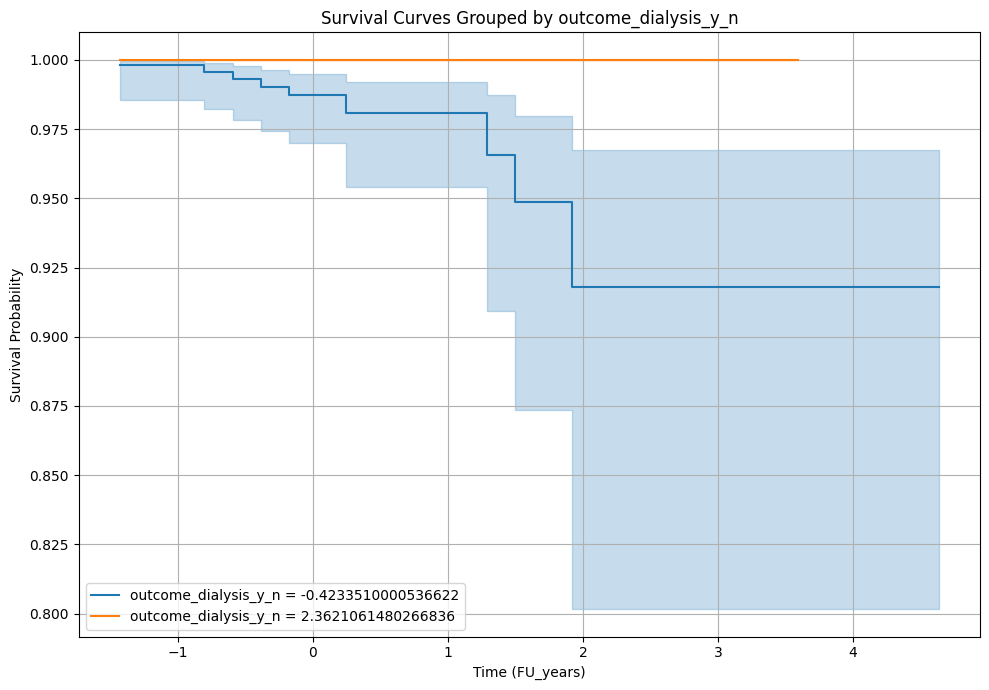

In [18]:
#18 Plot Kaplan-Meier Survival Curves by Dialysis Outcome

import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

fig, ax = plt.subplots(figsize=(10, 7))

# Get unique values of outcome_dialysis_y_n
outcome_groups = df['outcome_dialysis_y_n'].unique()

for group in sorted(outcome_groups):
    # Filter data for each group
    group_df = df[df['outcome_dialysis_y_n'] == group]

    # Fit Kaplan-Meier for the group
    kmf.fit(group_df['survival_time'], event_observed=group_df['event'], label=f'outcome_dialysis_y_n = {group}')

    # Plot the survival function
    kmf.plot_survival_function(ax=ax)

plt.title('Survival Curves Grouped by outcome_dialysis_y_n')
plt.xlabel('Time (FU_years)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.tight_layout()
plt.show()

**Step#18:** generates Kaplan-Meier survival curves stratified by the outcome_dialysis_y_n variable. It loops through each unique group in this column, fits a Kaplan-Meier estimator to the corresponding subset of the data, and plots the survival function on a shared axis. This visualization reveals differences in survival probabilities over time between groups, helping assess whether dialysis outcomes are associated with distinct survival trajectories. The plot includes labeled curves, confidence intervals, and axis annotations for interpretability.

In [19]:
#19 Display Cox Model Summary Statistics

import pandas as pd

# Display the model summary, which includes coefficients, hazard ratios, p-values, etc.
print("\nCox Proportional Hazards Model Summary:")
print(cph.summary)


Cox Proportional Hazards Model Summary:
                          coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                             
outcome_dialysis_y_n -0.773247   0.461512  0.145356       -1.058139   
FU_ESRD              -3.346556   0.035205  0.200508       -3.739544   
FU_15y_ESRD          -0.372843   0.688773  0.125387       -0.618596   
Death_NoHD           -0.152783   0.858316  0.064916       -0.280016   
treatment_response   -1.227492   0.293027  1.035279       -3.256601   
...                        ...        ...       ...             ...   
CB                   -0.261068   0.770228  0.253846       -0.758597   
CC                   -0.245473   0.782335  0.066666       -0.376135   
CD                   -0.218454   0.803760  0.095074       -0.404795   
biopsydate            0.072745   1.075456  0.051667       -0.028520   
xb                   -0.004152   0.995857  0.068084       -0.137594   

                      coef upper 95

**Step#19:** Displays the summary of the fitted Cox Proportional Hazards model using cph.summary. This output includes key statistics for each covariate: coefficients (coef), hazard ratios (exp(coef)), standard errors, confidence intervals, z-scores, p-values, and log-transformed p-values. These metrics help assess the strength, direction, and statistical significance of each variable’s association with survival time. For example, a negative coefficient with a hazard ratio below 1 suggests a protective effect, while a low p-value indicates strong evidence against the null hypothesis. This step is essential for interpreting model results and identifying influential predictors.

/tmp/ipython-input-3581663132.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['risk_score'] = cph.predict_partial_hazard(df[features])


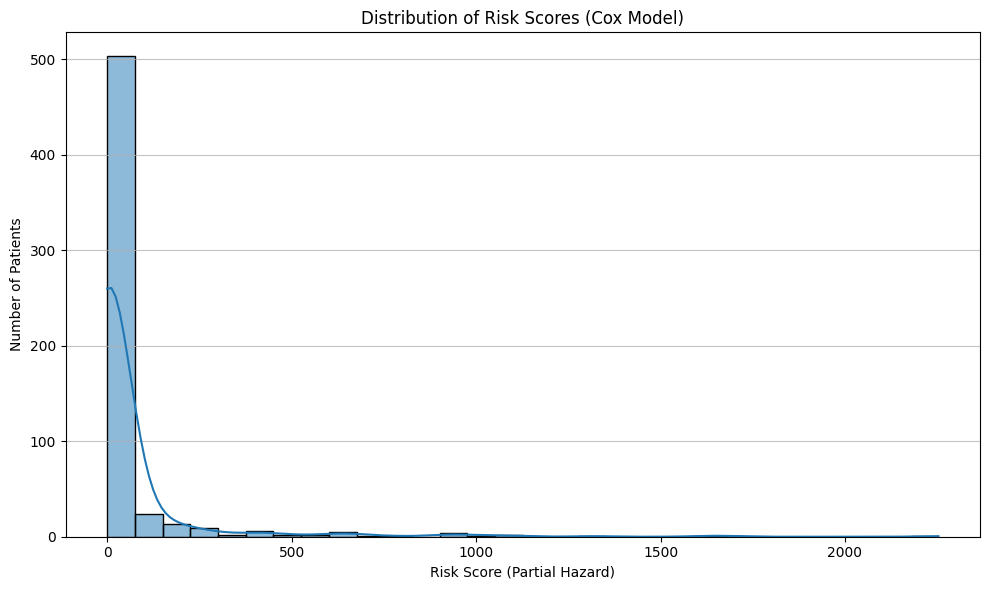

In [20]:
#20 Compute and Visualize Risk Scores from Cox Model

import matplotlib.pyplot as plt
import seaborn as sns

# Calculate risk scores and add to DataFrame before plotting
df['risk_score'] = cph.predict_partial_hazard(df[features])

plt.figure(figsize=(10, 6))
sns.histplot(df['risk_score'], kde=True, bins=30)
plt.title('Distribution of Risk Scores (Cox Model)')
plt.xlabel('Risk Score (Partial Hazard)')
plt.ylabel('Number of Patients')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

**Step#20:** calculates individual risk scores using the Cox model’s partial hazard predictions and stores them in a new column called "risk_score" within the DataFrame. These scores reflect each patient's relative risk of experiencing the event, based on their covariate profile. The step then visualizes the distribution of these scores using a histogram with kernel density estimation (KDE), revealing the spread and skewness of risk across the cohort. This plot helps identify high-risk subgroups and assess model calibration visually.

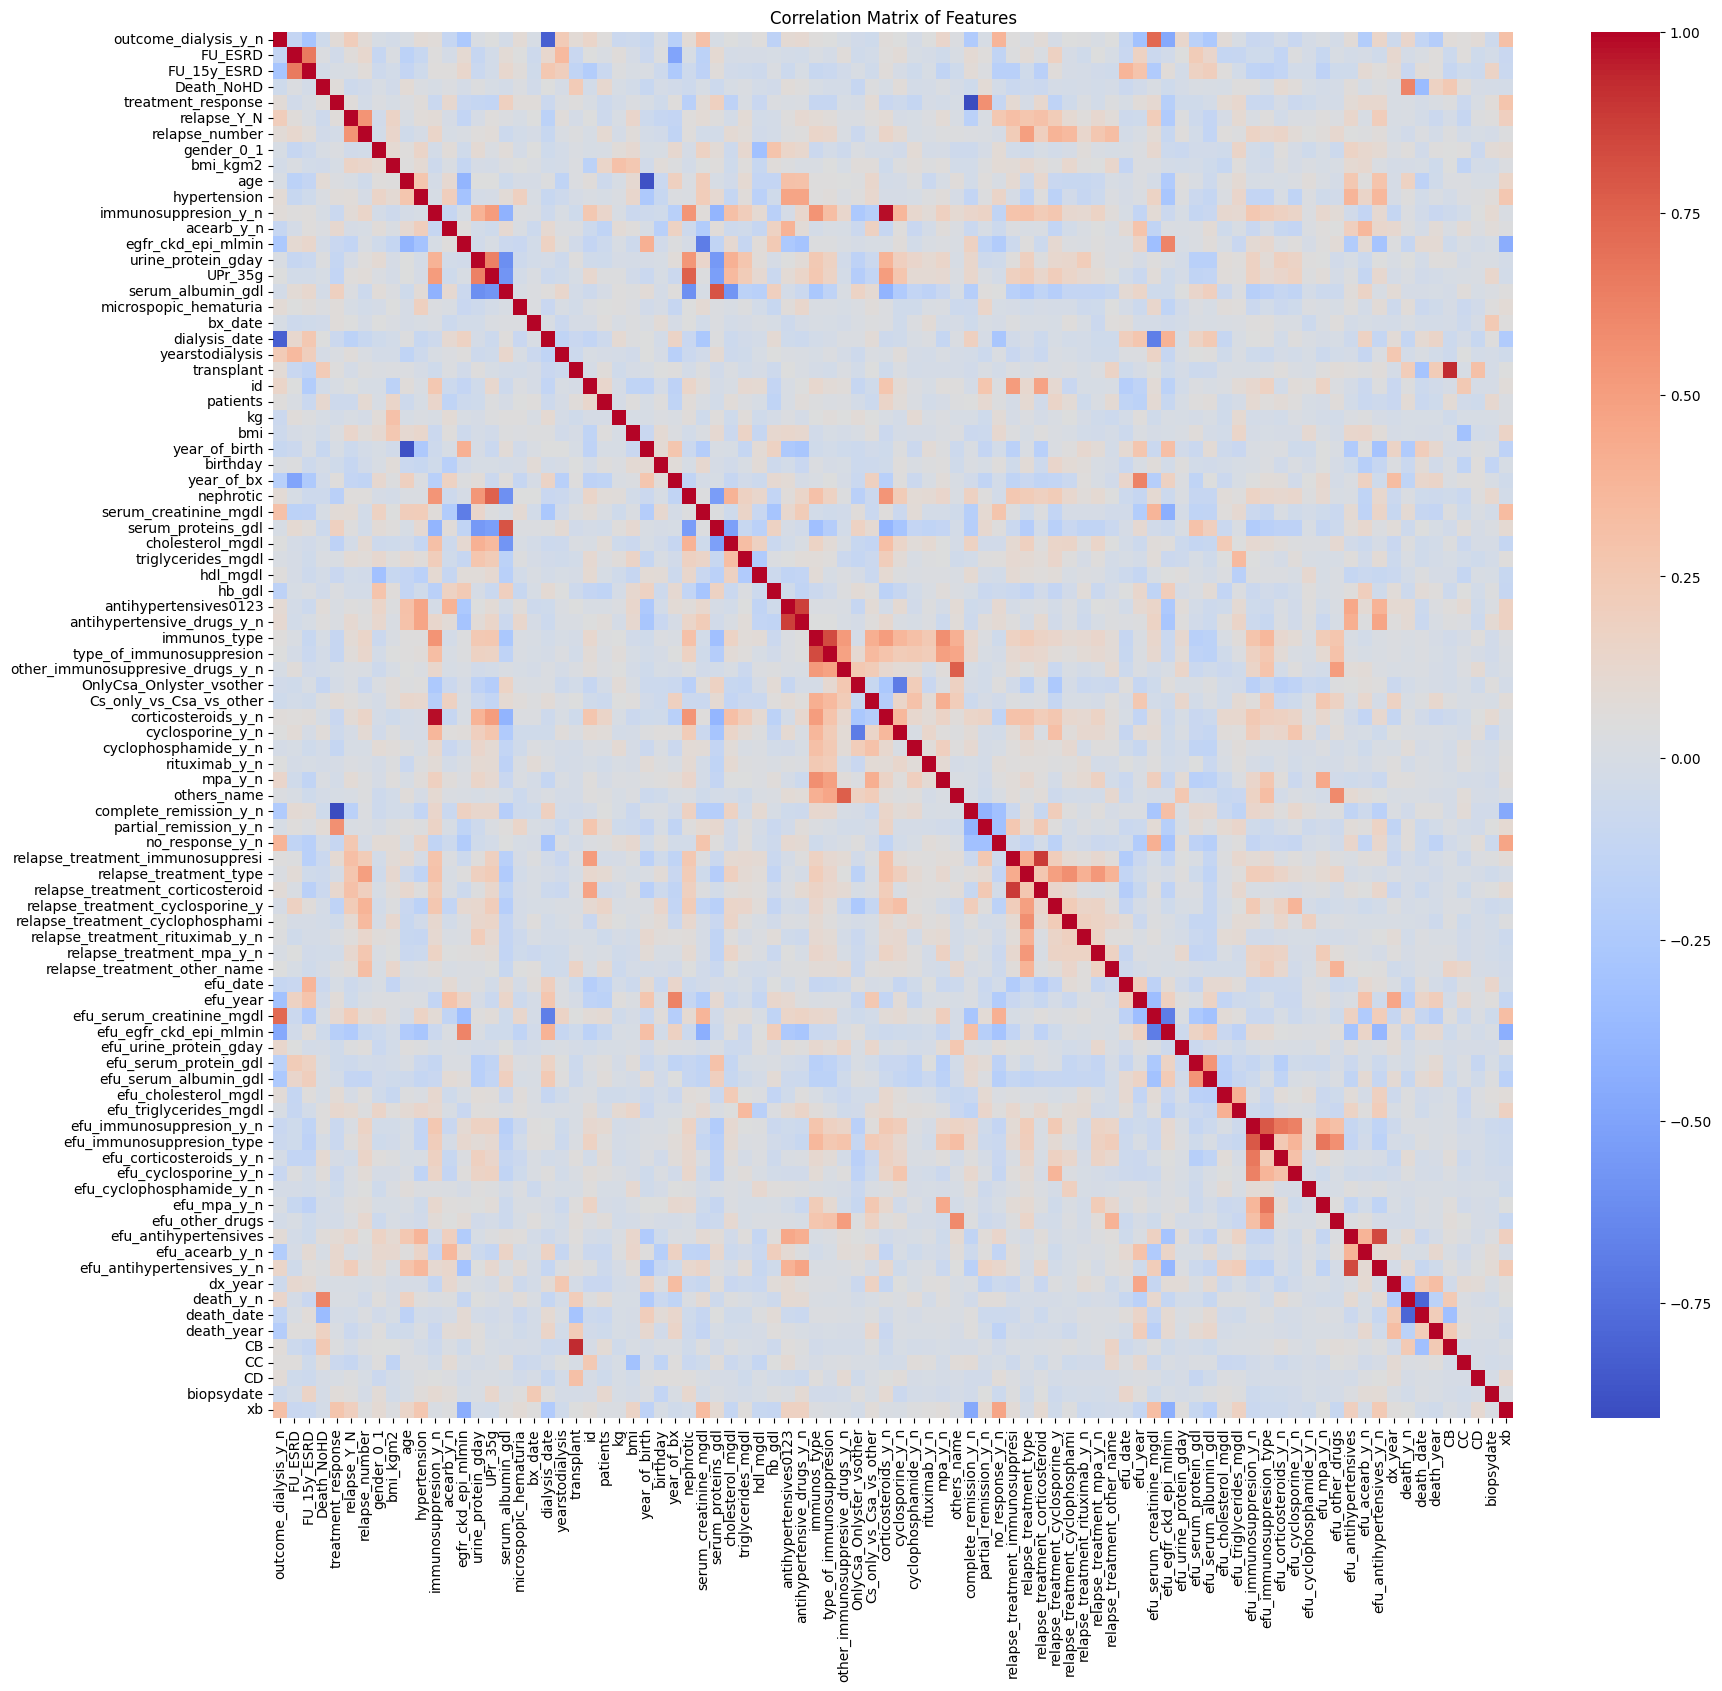


Highly correlated feature pairs (absolute correlation > 0.9):
corticosteroids_y_n - immunosuppresion_y_n: 0.98
complete_remission_y_n - treatment_response: -0.91
CB - transplant: 0.93


In [21]:
#21 Analyze and Visualize Feature Correlations

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix for the features
correlation_matrix = df[features].corr()

# Visualize the correlation matrix
plt.figure(figsize=(20, 18))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

# Identify highly correlated features (e.g., correlation > 0.9 or < -0.9)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            high_corr_pairs.append((col1, col2, correlation_matrix.iloc[i, j]))

if high_corr_pairs:
    print("\nHighly correlated feature pairs (absolute correlation > 0.9):")
    for pair in high_corr_pairs:
        print(f"{pair[0]} - {pair[1]}: {pair[2]:.2f}")
else:
    print("\nNo highly correlated feature pairs (absolute correlation > 0.9) found.")

**Step#21:** computes the correlation matrix for all selected features and visualizes it using a heatmap to reveal patterns of linear relationships across variables. After plotting, the step programmatically scans the matrix to detect pairs of features with extremely high correlation (absolute value greater than 0.9), which may indicate redundancy or multicollinearity that could distort model interpretation or inflate variance. Any such pairs are printed for review, helping guide decisions about feature removal, dimensionality reduction, or model regularization. This step strengthens the pipeline by ensuring feature quality and reducing unnecessary noise.

In [22]:
#22 Evaluate Model Performance Using Concordance Index
c_index = concordance_index(df['survival_time'], -cph.predict_partial_hazard(df[features]), df['event'])
print(f"Concordance Index: {c_index:.3f}")

Concordance Index: 0.947


**Step#22:** evaluates the performance of the Cox Proportional Hazards model using the concordance index (C‑index), a standard metric in survival analysis that measures how well the model’s predicted risk scores align with actual survival outcomes. The code computes the C‑index by comparing observed survival times with the negative partial hazard predictions—negative because higher hazards correspond to shorter survival, and the concordance function expects higher predicted values to indicate longer survival. The resulting score, printed to three decimal places, reflects the model’s discriminative ability, with values closer to 1.0 indicating excellent predictive performance.

In [23]:
#23 Export Cox Model Summary to File
with open(os.path.join(output_path, 'cox_model_summary.txt'), 'w') as f:
    f.write(str(cph.summary))

**Step#23:** saves the full Cox Proportional Hazards model summary to a text file named cox_model_summary.txt inside the designated output directory. By converting cph.summary to a string and writing it to disk, this step preserves all coefficients, hazard ratios, confidence intervals, and statistical metrics in a permanent, shareable format. This is an essential part of a well‑designed research pipeline, allowing collaborators—or your future self—to revisit the model’s results without needing to rerun the entire analysis.

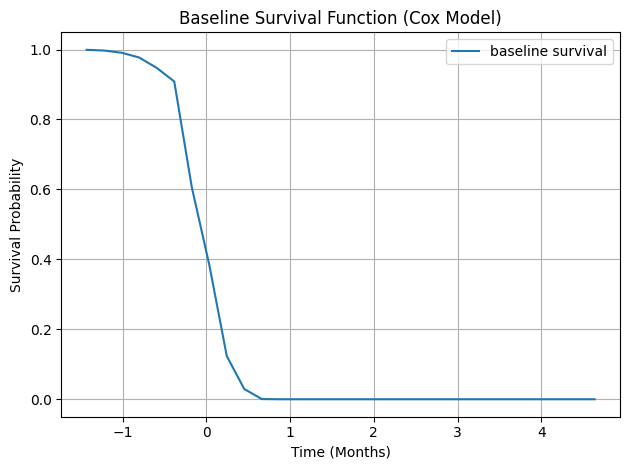

In [24]:
#24 Plot and Save Baseline Survival Curve
import matplotlib.pyplot as plt
cph.baseline_survival_.plot()
plt.title('Baseline Survival Function (Cox Model)')
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_path, 'baseline_survival_function.png'))
plt.show()

**Step#24:** generates and saves a plot of the baseline survival function from the fitted Cox model. The baseline survival curve represents the estimated survival probability over time for a hypothetical patient with all covariates set to zero (or reference levels). The code plots this function, formats the figure with titles, axis labels, and a grid, and then saves the resulting image to the output directory as baseline_survival_function.png. This step ensures that a key survival analysis diagnostic—how the baseline hazard evolves over time—is preserved as a reusable figure for reports, presentations, or publication.

In [25]:
#25 Generate and Export Patient Risk Scores
df['risk_score'] = cph.predict_partial_hazard(df[features])
df.to_csv(os.path.join(output_path, 'fsgs_with_risk_scores.csv'), index=False)


**Step#25:** generates a new column called "risk_score" by applying the Cox model’s partial hazard predictions to the selected features. These risk scores quantify each patient’s relative hazard based on the model, making them essential for downstream clinical interpretation, stratification, or reporting. After adding the scores to the DataFrame, the entire dataset—including all original variables and the new risk scores—is saved as a CSV file in the specified output directory. This ensures the enriched dataset is preserved for further analysis, external validation, or integration into other tools.